# Interactive Data Visualization
##### (C) 2023-2025 Timothy James Becker: [revision 1.0](),  [GPLv3 license](https://www.gnu.org/licenses/gpl-3.0.html) 

#### <u>Missingness in Data</u>

Data has missing values when looking at multiple columns such as the NHANES 2018 data used in [07_Data_Cleaning.ipynb]. But upon closer inspection data is missing for different reasons. It could be missing based on some random process that has corrupted the data, it could be missing because someone was embarrassed about the survey question, it could be missing because of data privacy issues.  Let look more formally at the type of missing values or the missingness of the data below. There is a nice MICE video [here](https://www.youtube.com/watch?v=WPiYOS3qK70)

##### <b>Missing Completely at Random MCAR</b>
When a missing value is encountered in a column but it cannot be predicted by any other column of data (IE it is completely independent from all other columns of data). We say this is missing completely at random or [MCAR](https://stefvanbuuren.name/fimd/sec-MCAR.html).

##### <b>Missing at Random (MAR)</b>
When the missing value has some dependency with one or more of the other columns of data in which case its value is associated with the other values (IE the other values can predict more than background the value of a missing value in this column).  We say this is missing at random or [MAR](https://stefvanbuuren.name/fimd/sec-MCAR.html).

##### <b>Missing not-at random (MNAR)</b>
When the missing value was removed for privacy issues or some specific reason like they were embarrassed. We say this is missing not at random or [MNAR](https://stefvanbuuren.name/fimd/sec-MCAR.html).


##### <b>Which one can we try to estimate? </b>
We will see that [MAR](https://stefvanbuuren.name/fimd/sec-MCAR.html) is the type of missingness that can be estimated well by methods such as multi-variate imputation by chained equations [MICE](https://github.com/amices/mice?tab=readme-ov-file)

<img src="figures/data_imputation_overview.png" alt="data_imputation_overview" width="700px">


#### <u>Missing Data I (remove)</u>
We discussed one simple method is to remove data (after projection in order to lose less). Let’s use our NHANES data and remove any row that has at least one missing value. Then we will project first and then remove and explore how much of the 10,000 rows of data we lose in this filtering process.

In [125]:
#[Load and Process the Dataset: NHANES-10000]
from matplotlib import pyplot as plt
import numpy as np
import gzip
with gzip.GzipFile('data/NHANES.csv.gz','rb') as f:
    #gp from raw data into filtered and clean data--------------------------------------------------
    raw = [row.decode('utf-8').replace('\n','').replace('\r','').split(',') for row in f.readlines()]
    header,data = raw[0],raw[1:]
idx = {header[i]:i for i in range(len(header))} #build the dictionary so we can select columns by name
print(header)
print(len(data))
print(len(header))

['SurveyYr', 'ID', 'Gender', 'Age', 'AgeDecade', 'AgeMonths', 'Race1', 'Race3', 'Education', 'MaritalStatus', 'HHIncome', 'HHIncomeMid', 'Poverty', 'HomeRooms', 'HomeOwn', 'Work', 'Weight', 'Length', 'HeadCirc', 'Height', 'BMI', 'BMICatUnder20yrs', 'BMI_WHO', 'Pulse', 'BPSysAve', 'BPDiaAve', 'BPSys1', 'BPDia1', 'BPSys2', 'BPDia2', 'BPSys3', 'BPDia3', 'Testosterone', 'DirectChol', 'TotChol', 'UrineVol1', 'UrineFlow1', 'UrineVol2', 'UrineFlow2', 'Diabetes', 'DiabetesAge', 'HealthGen', 'DaysPhysHlthBad', 'DaysMentHlthBad', 'LittleInterest', 'Depressed', 'nPregnancies', 'nBabies', 'Age1stBaby', 'SleepHrsNight', 'SleepTrouble', 'PhysActive', 'PhysActiveDays', 'TVHrsDay', 'CompHrsDay', 'TVHrsDayChild', 'CompHrsDayChild', 'Alcohol12PlusYr', 'AlcoholDay', 'AlcoholYear', 'SmokeNow', 'Smoke100', 'Smoke100n', 'SmokeAge', 'Marijuana', 'AgeFirstMarij', 'RegularMarij', 'AgeRegMarij', 'HardDrugs', 'SexEver', 'SexAge', 'SexNumPartnLife', 'SexNumPartYear', 'SameSex', 'SexOrientation']
10000
75


In [8]:
cols = sorted(header) #we will revise this cell to project the cols we want
cols[0:10]

['Age',
 'Age1stBaby',
 'AgeDecade',
 'AgeFirstMarij',
 'AgeMonths',
 'AgeRegMarij',
 'Alcohol12PlusYr',
 'AlcoholDay',
 'AlcoholYear',
 'BMI']

In [9]:
clean = []
for d in data:
    row = [d[idx[e]] for e in cols]     #pick the cols we want and clear the rest
    if not any([e=='NA' for e in row]): #this row is good
        clean += [row]                  #add it to our dataset
print('We have %s out of %s rows'%(len(clean),len(data)))

We have 0 out of 10000 rows


Zero rows is not great for visualization! Lets now project the rows we want and then filter them to see what we have left:

In [26]:
cols = ['Age','BMI','Gender','Diabetes','HardDrugs']

In [27]:
clean = []
for d in data:
    row = [d[idx[e]] for e in cols]     #pick the cols we want and clear the rest
    if not any([e=='NA' for e in row]): #this row is good
        clean += [row]                  #add it to our dataset
print('We have %s out of %s rows'%(len(clean),len(data)))

We have 5732 out of 10000 rows


In [36]:
sorted(set([e[idx['HardDrugs']] for e in data]))

['NA', 'No', 'Yes']

This is much better and now we have 5732 complete rows of data which means we lost around half of the data. Which cols do you think are MAR? Which ones are MNAR?

#### <u>Missing Data II (estimate badly)</u>
If we have some rows we think are MAR we can try to estimate the values using basic univariate methods which are actually not very good. But they will help use to understand the multivariate methods even though they are technically a type of predictive model! If we take a specific column and build its histogram as we have done in [07_Data_Cleaning.ipynb] we can sample from that distribution effectively thereby coming up with a reasonable univariate estimate. Before we do that lets instead use an even worse estimate that may be your first idea: take the mean or mode of the column and use that as an estimate.


In [126]:
#covert our data to numeric by either using if/else or by using a dictionary to map values to numbers
import re
age_data = [(float(e[idx['Age']]) if e[idx['Age']].isdecimal() else np.nan) for e in data]
bmi_data = [(float(e[idx['BMI']]) if re.match(r'^-?\d+(?:\.\d+)$', e[idx['BMI']]) is not None else np.nan) for e in data]
gen = {'female':0,'male':1,'NA':np.nan}
gen_data = [gen[e[idx['Gender']]] for e in data]
dia = {'Yes':1,'No':0,'NA':np.nan}
dia_data = [dia[e[idx['Diabetes']]] for e in data]
hard = {'Yes':1,'No':0,'NA':np.nan}
hard_data = [hard[e[idx['HardDrugs']]] for e in data]
age_data[0:10]

[28.0, 14.0, 80.0, 22.0, 1.0, 39.0, 18.0, 61.0, 73.0, 40.0]

In [90]:
#now lets do some bad univariate estimating: the mean of the non-missing values
age_data = np.asarray(age_data)
age_data[np.isnan(age_data)] = np.mean(age_data[~np.isnan(age_data)]) #we put the mean where we see nan

bmi_data = np.asarray(bmi_data)
bmi_data[np.isnan(bmi_data)] = np.mean(bmi_data[~np.isnan(bmi_data)])

gen_data = np.asarray(gen_data)
gen_data[np.isnan(gen_data)] = np.mean(gen_data[~np.isnan(gen_data)])

dia_data = np.asarray(dia_data)
dia_data[np.isnan(dia_data)] = np.mean(dia_data[~np.isnan(dia_data)])

hard_data = np.asarray(hard_data)
hard_data[np.isnan(hard_data)] = np.mean(hard_data[~np.isnan(hard_data)])

#glue all the data back together now
n = len(age_data)
new_data = np.concatenate([age_data.reshape(n,1),bmi_data.reshape(n,1),
                           gen_data.reshape(n,1),dia_data.reshape(n,1),
                           hard_data.reshape(n,1)],axis=1)
new_data

array([[28.        , 23.3       ,  0.        ,  0.        ,  1.        ],
       [14.        , 33.75      ,  1.        ,  0.        ,  0.18473547],
       [80.        , 26.64172729,  1.        ,  0.        ,  0.18473547],
       ...,
       [48.        , 36.7       ,  1.        ,  0.        ,  0.        ],
       [52.        , 29.2       ,  1.        ,  0.        ,  1.        ],
       [57.        , 26.64172729,  0.        ,  0.        ,  0.18473547]])

(array([1.560e+03, 3.317e+03, 3.655e+03, 1.049e+03, 3.080e+02, 7.300e+01,
        2.400e+01, 9.000e+00, 2.000e+00, 3.000e+00]),
 array([12.88 , 19.717, 26.554, 33.391, 40.228, 47.065, 53.902, 60.739,
        67.576, 74.413, 81.25 ]),
 <BarContainer object of 10 artists>)

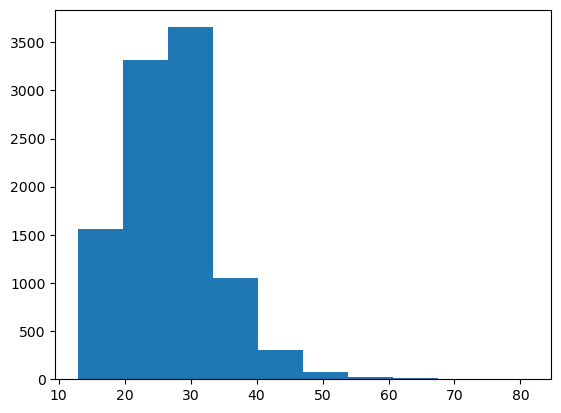

In [93]:
plt.hist(bmi_data)

Because we supplied the mean of the non-missing values, we will end up with a final dataset that will have a similar mean for each column. But what will happen when we visualize that? It looks like the mean value get over represented which changes the distribution of your data. This means visualization will be terrible...

In [94]:
#use the empirical univariate distribution to estiamte each value
age_data = [(float(e[idx['Age']]) if e[idx['Age']].isdecimal() else np.nan) for e in data]
bmi_data = [(float(e[idx['BMI']]) if re.match(r'^-?\d+(?:\.\d+)$', e[idx['BMI']]) is not None else np.nan) for e in data]
gen = {'female':0,'male':1,'NA':np.nan}
gen_data = [gen[e[idx['Gender']]] for e in data]
dia = {'Yes':1,'No':0,'NA':np.nan}
dia_data = [dia[e[idx['Diabetes']]] for e in data]
hard = {'Yes':1,'No':0,'NA':np.nan}
hard_data = [hard[e[idx['HardDrugs']]] for e in data]
age_data[0:10]

[28.0, 14.0, 80.0, 22.0, 1.0, 39.0, 18.0, 61.0, 73.0, 40.0]

Here we are now going to be a empirical distribution for each column (univariate estimate) then we will sample from this distribution when it comes time to pick a value when NA is encountered.

In [95]:
def get_est(col_data):
    n = len(col_data)                       #original data size
    col_data = np.asarray(col_data)         #make sure it is a numpy array so we can find nan
    col_in = col_data[~np.isnan(col_data)]  #grab the non-nan values
    m = len(col_in)                         #how many values are present in the non-nan data?
    hist = {}                               #build up a histogram and total counts to make the prob distribution
    for e in col_in:                        #histogram counts every value
        if e not in hist: hist[e]  = 1/m    #and divides by total number
        else:             hist[e] += 1/m    #to produce the empircial distribution
    est = np.random.choice([h for h in hist],n-m,replace=True,p=[hist[h] for h in hist])
    return est

In [96]:
age_data = np.asarray(age_data)
age_data[np.isnan(age_data)] = get_est(age_data)

bmi_data = np.asarray(bmi_data)
bmi_data[np.isnan(bmi_data)] = get_est(bmi_data)

gen_data = np.asarray(gen_data)
gen_data[np.isnan(gen_data)] = get_est(gen_data)

dia_data = np.asarray(dia_data)
dia_data[np.isnan(dia_data)] = get_est(dia_data)

hard_data = np.asarray(hard_data)
hard_data[np.isnan(hard_data)] = get_est(hard_data)

In [97]:
n = len(age_data)
new_data = np.concatenate([age_data.reshape(n,1),bmi_data.reshape(n,1),
                           gen_data.reshape(n,1),dia_data.reshape(n,1),
                           hard_data.reshape(n,1)],axis=1)
print(new_data,new_data.shape)

[[28.   23.3   0.    0.    1.  ]
 [14.   33.75  1.    0.    1.  ]
 [80.   25.36  1.    0.    0.  ]
 ...
 [48.   36.7   1.    0.    0.  ]
 [52.   29.2   1.    0.    1.  ]
 [57.   19.41  0.    0.    0.  ]] (10000, 5)


This has the advantage of now having all 10,000 rows of data but we will have the correct empirical distribution instead of a single mean value being blasted on more than 1K rows which would change the distribution of each column but not the mean of each column.

(array([1.725e+03, 3.669e+03, 2.991e+03, 1.149e+03, 3.410e+02, 8.300e+01,
        2.700e+01, 1.000e+01, 2.000e+00, 3.000e+00]),
 array([12.88 , 19.717, 26.554, 33.391, 40.228, 47.065, 53.902, 60.739,
        67.576, 74.413, 81.25 ]),
 <BarContainer object of 10 artists>)

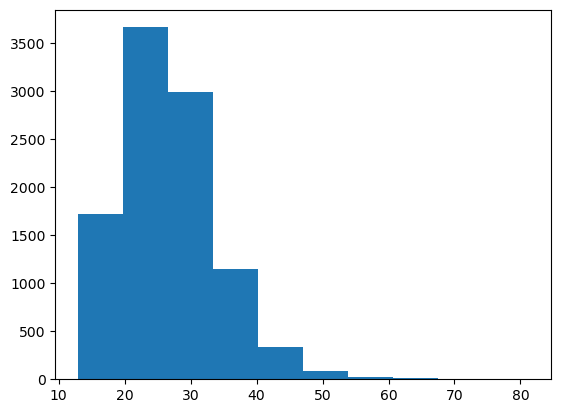

In [98]:
plt.hist(bmi_data)

Notice how this distribution is more accurate and the previous mean estimate which actually changes the distribution...

#### <u>Data Imputation (estimate well)</u>
Finally we can work to put together a better estimate. First, we will explore how some variables many depend on each other to determine if the MAR principle applies. Then we will make use of multivariate imputation by chained equations [MICE](https://www.youtube.com/watch?v=WPiYOS3qK70) which will do a much better job at estimating missing values (without changing distributions).


In [108]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [109]:
age_data = [(float(e[idx['Age']]) if e[idx['Age']].isdecimal() else np.nan) for e in data]
bmi_data = [(float(e[idx['BMI']]) if re.match(r'^-?\d+(?:\.\d+)$', e[idx['BMI']]) is not None else np.nan) for e in data]
gen = {'female':0,'male':1,'NA':np.nan}
gen_data = [gen[e[idx['Gender']]] for e in data]
dia = {'Yes':1,'No':0,'NA':np.nan}
dia_data = [dia[e[idx['Diabetes']]] for e in data]
hard = {'Yes':1,'No':0,'NA':np.nan}
hard_data = [hard[e[idx['HardDrugs']]] for e in data]

In [110]:
age_data = np.asarray(age_data)
bmi_data = np.asarray(bmi_data)
gen_data = np.asarray(gen_data)
dia_data = np.asarray(dia_data)
hard_data = np.asarray(hard_data)
n = len(age_data)
D = np.concatenate([age_data.reshape(n,1),bmi_data.reshape(n,1),
                    gen_data.reshape(n,1),dia_data.reshape(n,1),
                    hard_data.reshape(n,1)],axis=1)
print(D,D.shape) #this will have the nan which will will use MICE to fill in

[[28.   23.3   0.    0.    1.  ]
 [14.   33.75  1.    0.     nan]
 [80.     nan  1.    0.     nan]
 ...
 [48.   36.7   1.    0.    0.  ]
 [52.   29.2   1.    0.    1.  ]
 [57.     nan  0.    0.     nan]] (10000, 5)


In [113]:
imp = IterativeImputer(max_iter=20,random_state=0) #this MICE
imp.fit(D)
X = imp.transform(D)
X #no more nan values...

array([[28.        , 23.3       ,  0.        ,  0.        ,  1.        ],
       [14.        , 33.75      ,  1.        ,  0.        ,  0.18886719],
       [80.        , 31.69002274,  1.        ,  0.        ,  0.24908126],
       ...,
       [48.        , 36.7       ,  1.        ,  0.        ,  0.        ],
       [52.        , 29.2       ,  1.        ,  0.        ,  1.        ],
       [57.        , 28.81698864,  0.        ,  0.        ,  0.15298159]])

Since we had to convert to numeric values for MICE to work, we will have to map our values back into the regular ranges if we want to make our imputed NHANES file as nice as the original. Categorical data specifically will need some inverse mapping. For example, if we originally encoded 'female' as 0 and 'male' as 1 then it may make sense to round the values from 0 to 1 so that they will go back to 'female' and 'male'. That is to say you have to deal with fractional categorical values and rounding is one way to do that.

In [120]:
gen_m  = {0:'female',1:'male'}
dia_m  = {0:'No',1:'Yes'}
hard_m = {0:'No',1:'Yes'}
imp_data = []
for i in range(len(D)):
    imp_row = [X[i][0],(0 if X[i][0]==D[i][0] else 1),
               X[i][1],(0 if X[i][1]==D[i][1] else 1),
               gen_m[round(X[i][2])],(0 if X[i][2]==D[i][2] else 1),
               dia_m[round(X[i][3])],(0 if X[i][3]==D[i][3] else 1),
               hard_m[round(X[i][4])],(0 if X[i][4]==D[i][4] else 1)]
    imp_data += [imp_row]
imp_data[0:10]

[[28.0, 0, 23.3, 0, 'female', 0, 'No', 0, 'Yes', 0],
 [14.0, 0, 33.75, 0, 'male', 0, 'No', 0, 'No', 1],
 [80.0, 0, 31.690022736868894, 1, 'male', 0, 'No', 0, 'No', 1],
 [22.0, 0, 22.74, 0, 'male', 0, 'No', 0, 'Yes', 0],
 [1.0, 0, 21.726246917722694, 1, 'male', 0, 'No', 0, 'No', 1],
 [39.0, 0, 27.46, 0, 'female', 0, 'No', 0, 'No', 0],
 [18.0, 0, 22.46, 0, 'male', 0, 'No', 0, 'No', 0],
 [61.0, 0, 22.03, 0, 'male', 0, 'Yes', 0, 'No', 0],
 [73.0, 0, 32.42, 0, 'female', 0, 'No', 0, 'No', 1],
 [40.0, 0, 28.07, 0, 'male', 0, 'No', 0, 'No', 0]]

In [ ]:
#pack it up as a new file we now know exactly which values have been imputed :)
s = ','.join(['Age','Age_imp','BMI','BMI_imp','Gender','Gender_imp',
              'Diabetes','Diabetes_imp','HardDrugs','HardDrugs_imp'])+'\n'
s += '\n'.join([','.join([str(x) for x in row]) for row in imp_data])+'\n'
with open('nhanes.imp.csv','w') as f: f.write(s)

#### <u>Intuition on how and why MICE works well</u>

When columns move in a similar manner they are associated which is known as correlation. If we have a column x and a column y we can write it as:

$r_{xy} = \displaystyle\frac{\sum_{i=1}^{n} (x_i-\bar{x})(y_i-\bar{y}) }{\sqrt{ \sum_{i=1}^{n}(x_i-\bar{x})^2 \sum_{i=1}^{n}(y_i-\bar{y})^2}} = 
\frac{\sum_{i=1}^{n} (x_i-\bar{x})(y_i-\bar{y}) }{(n-1) \sqrt{ s_x^2 s_y^2 }}
$

The bar terms are the mean of those columns. If we are close to zero the two columns are basically independant and they don't need to be processed together with MICE. On the other hand, if they are close to -1 or 1 they are entirely dependant or associated and they should be jointly utilized in MICE. The in between range is also useful since it represents some minor association.


We can calculate these values in our data using numpy/scipy/scikit-learn and also plot each column pair which is known as pair-wise correlation plots. Here we will show how to check and plot one pair:

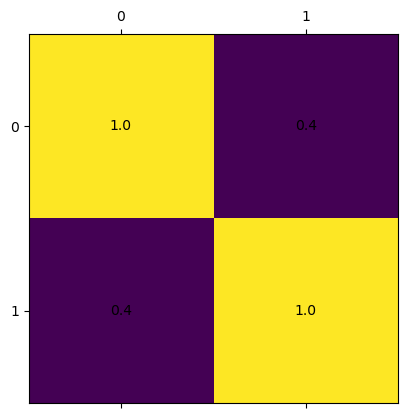

In [159]:
age_data = np.asarray(age_data)
age_idx  = ~np.isnan(age_data)

bmi_data = np.asarray(bmi_data)
bmi_idx  = ~np.isnan(bmi_data)

corr_idx = np.logical_and(age_idx,bmi_idx)
age_in   = age_data[corr_idx]
bmi_in   = bmi_data[corr_idx]

corr = np.corrcoef(age_in,bmi_in)

fig, ax = plt.subplots()
ax.matshow(corr, cmap='viridis')
for (i, j), z in np.ndenumerate(corr):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

If we have non-zero correlation then we can build general linear models and use then iteratively to estimate (predict) the missing values that we encounter. In the example above we have 0.4 which is high enough that MICE will help and improve the univariate analysis we previously did.  This is the basic MICE premise but more in-depth discussion can be found in this [paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC3074241/pdf/MPR-20-40.pdf).

#### Exercises
#### [1] Using the new nhanes.imp.csv try to complete a scatter plot with any two columns as x and y
#### [2] try to make a visual mark if your plotted circle is imputed either by making them a different shape or changing the color to visually indicate that imputation is being used.
#### [3*] using the code supplied in this notebook pick additional columns of data that were not shown and produce the final MICE imputed file
#### [4*] complete a visualization of your selected columns in part [3*] and make a visual indicator of any imputed values as required in [2]